## Analyzing Sandisk Memory Chip Reviews for Insights

The following data came from the following source: http://jmcauley.ucsd.edu/data/amazon/. The top products are available in the **electronics_reviews_sorted_20kfirst.csv** file, and within it, the most popular product is the sandisk memory chip. The asin is the Amazon-specific product key for that product / product group. 

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords

In [9]:
electronics = pd.read_csv('electronics_reviews_sorted_20kfirst.csv')

In [10]:
electronics.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,counts
0,1336615,1336615,B007WTAJTO,"[0, 0]",5,"Purchased this for my device, it worked as adv...","10 25, 2013",A18K1ODH1I2MVB,0mie,MOAR SPACE!!!,1382659200,4914
1,1338394,1338394,B007WTAJTO,"[0, 0]",5,"I use this card to back up some of the files, ...","04 7, 2014",A23VI3E0M5KYES,George H.,SanDisk,1396828800,4914
2,1338378,1338378,B007WTAJTO,"[0, 0]",5,I bought 3 when they were on sale but I did bu...,"05 13, 2014",A302II84DZN7IU,Gee 35,go pro,1399939200,4914
3,1338379,1338379,B007WTAJTO,"[1, 1]",5,Works well for the Galaxy S3 and provides addi...,"09 22, 2012",A2PIPECHFC8KPS,gellikit,Useful,1348272000,4914
4,1338380,1338380,B007WTAJTO,"[0, 0]",5,Popped this into my Nvidia shield for extra st...,"12 8, 2013",A2RULNH1LXYG1O,"Gem Box ""tech junkie""",Good SD Card for the Price,1386460800,4914


In [11]:
sandisk_asin = electronics['asin'][0]
sandisk_asin

'B007WTAJTO'

In [12]:
sandisk = electronics[electronics['asin']==sandisk_asin]
sandisk = sandisk[sandisk['reviewText'].notna()]

In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
tokenizer = nltk.tokenize.TreebankWordTokenizer()

In [14]:
def text_prepare(text):    
    """
        text: a string
        
        return: modified initial string pre-processed 
        1. converting to lower-case
        2. replace special characters with a space
        3. remove othe symbols
        4. remove stopwords
    """
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = text.lower()
    text = [word for word in tokenizer.tokenize(text) if word not in STOPWORDS]
    text = ' '.join(text)
    return text
def text_splitter(texts):
    split_texts = [tokenizer.tokenize(text) for text in texts]
    return split_texts
def dict_counter(split_texts):
    # split, then flatten the nested list of texts
    flattened_list = [word for text in split_texts for word in text]
    # init the dict
    words_counts_dict = dict()
    for word in flattened_list: 
        # if there is no key, get will return 0 (second argument default = 0), and then add 1 
        # if there is a pre-existing key, it will add 1 to the pre-existing number
        # the loop loops through every word occurence
        words_counts_dict[word] = words_counts_dict.get(word, 0) + 1
    return words_counts_dict

In [15]:
prepared_texts = [text_prepare(text) for text in sandisk['reviewText']]
split_texts = text_splitter(prepared_texts)
words_counts = dict_counter(split_texts)

## Visualizing the Frequency of Words

Plot the distribution of word frequencies. We see that most words (~80%) occur between 1-10 times. We'll exclude these from our vector representations of words to eliminate noise

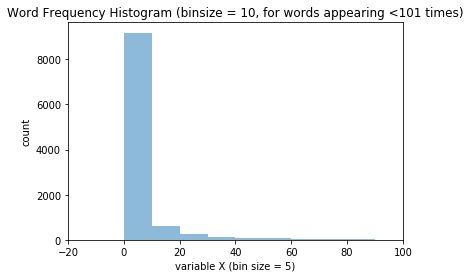

Number of words in vocab is 10740


In [16]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = words_counts.values()

# fixed bin size
bins = np.arange(0, 100, 10) # fixed bin size

plt.xlim([-20, 100])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Word Frequency Histogram (binsize = 10, for words appearing <101 times)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()
print('Number of words in vocab is %s' % len(words_counts.keys()))


Given the above distribution, to eliminate noise, we will use only the top 2000 words in our model vocabulary. 

In [89]:
DICT_SIZE = 10740
TOP_WORDS_LIST = sorted(words_counts, key = words_counts.__getitem__, reverse = True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: value for value, key in enumerate(TOP_WORDS_LIST)}
INDEX_TO_WORDS = {key: value for key, value in enumerate(TOP_WORDS_LIST)}


In [90]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    text = tokenizer.tokenize(text)
    ALL_WORDS = words_to_index.keys()
    result_vector = np.zeros(dict_size)
    for word in text: 
        if word in ALL_WORDS:
            result_vector[words_to_index.get(word)] += 1
    return result_vector

In [91]:
from scipy import sparse as sp_sparse

In [92]:
X_train, X_test, y_train, y_test = train_test_split(prepared_texts, sandisk['overall'], test_size=0.2)

In [93]:
# create sparse vector representaitons of our bag of words representations of reviews

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

## Find out what words are associated with positive sentiment and negative sentiment 

In the following steps we'll investigate what drivers of our star score may be. In a sense, this may shed light on product features that consumers like and product features that are problematic. 

We will use correlation, because in multivariate regression, colinearity may cause misleading regression weights. 

In [22]:
import numpy as np

correl = [(n,np.corrcoef(np.asarray(X_train_mybag[:,n].todense()).reshape(-1), y_train)[0,1]) for n in range(DICT_SIZE)]
index, correlation = zip(*correl)

correl_array = np.array(list(correlation))

min_idx = np.argsort(correl_array)[:50]
min_vals = correl_array[min_idx]

max_idx = np.flip(np.argsort(correl_array)[-50:], axis = 0)
max_vals = correl_array[max_idx]


In [23]:
for i, v in zip(min_idx, min_vals):
    print(INDEX_TO_WORDS.get(i), v)

months -0.2659524029693055
return -0.2618115783695762
tried -0.2514089720513546
card -0.23886567721293225
lost -0.21024947029578395
back -0.20982958920377495
died -0.20765789148262245
replacement -0.20207856701460827
even -0.19128292974093253
failed -0.1906604449798398
started -0.1904482996475814
stopped -0.18795341204415106
dead -0.18065460874817948
bad -0.17721881299629677
different -0.1697044981767688
thought -0.16900127413810107
defective -0.16807436675258988
problem -0.16773159661390938
removed -0.16511449475297227
another -0.1633818117113342
luck -0.16179933638001462
would -0.16092744772691284
format -0.157974411313238
refund -0.15687682863729926
error -0.1551917638569165
could -0.1526470532977449
get -0.15216813883747626
disappointed -0.15030281867095294
first -0.1500816422869223
common -0.14989199468579106
gone -0.14985603083017696
month -0.1483796892119938
returned -0.1483318315480041
recognize -0.14601319829327897
weeks -0.14298280103731453
happened -0.1410527722977929
send -

In [24]:
for i, v in zip(max_idx, max_vals):
    print(INDEX_TO_WORDS.get(i), v)

orks 0.09060671786018278
space 0.08749376326345833
great 0.08251692132871924
price 0.0787778719229928
reat 0.06913210679170727
fast 0.0627791474576272
works 0.06057109586026598
storage 0.05501503482685981
perfect 0.05317525603525928
highly 0.051844085505744854
tablet 0.04479536646755473
perfectly 0.04408030291767827
room 0.04405811047708518
plenty 0.043249073929109136
holds 0.04313806528229153
pleased 0.042248100643867026
ighly 0.042180160565504006
anyone 0.04064572465927654
extra 0.03800135669712892
videos 0.03628034440382322
fits 0.03486242319068984
se 0.03384995699265955
sing 0.03361487588347965
xcellent 0.03320200337112696
whatever 0.03255558953664474
allows 0.03192851443907796
plug 0.03189199954748366
urface 0.03165714603980076
comes 0.031132730461864058
easy 0.031091367793607466
capacity 0.030891750076552028
ove 0.03064225242252348
best 0.030235245905376382
performed 0.029939881539453348
lots 0.02992000265643504
instantly 0.029615296660675475
library 0.029539563366100117
recommen

## How accurately can we predict the star score using these 100 words ? 

Use linear and lasso (normalized regression) to predict star score using words. There is no exact practical use for this, but it may be interesting to see how well we can explain star scores using these 100 words. 

In [94]:
indices = np.concatenate((min_idx, max_idx), axis = 0)

X_train_mybag_small = X_train_mybag.tocsc()[:,indices]
X_test_mybag_small = X_test_mybag.tocsc()[:,indices]

In [95]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LassoLarsCV
from sklearn import linear_model

In [96]:
LassoModel = LassoLarsCV(cv=5).fit(X_train_mybag_small.toarray(), y_train)
LinearModel = linear_model.LinearRegression().fit(X_train_mybag_small.toarray(), y_train)

In [28]:
print('standard deviation of star score is %s' %
     (y_train.std()))

print('\nLASSO model has a R^2 score of %s on the train set' %
      (LassoModel.score(X_train_mybag_small, y_train)))

LassoFit = LassoModel.predict(X_train_mybag_small)

print('\nLASSO model has a mean absolute error of %s stars on the train set' %
     (mean_absolute_error(y_train, LassoFit)))

print('\nLinear model has a R^2 score of %s on the train set' %
      (LinearModel.score(X_train_mybag_small, y_train)))

LinearFit = LinearModel.predict(X_train_mybag_small)

print('\nLinear model has a mean absolute error of %s stars on the train set' %
     (mean_absolute_error(y_train, LinearFit)))

standard deviation of star score is 1.002599213954883

LASSO model has a R^2 score of 0.40167789135457 on the train set

LASSO model has a mean absolute error of 0.4915773078270914 stars on the train set

Linear model has a R^2 score of 0.40925105597620437 on the train set

Linear model has a mean absolute error of 0.49683308541854165 stars on the train set


In [29]:
print('standard deviation of star score is %s' %
     (y_test.std()))

LassoFitTest = LassoModel.predict(X_test_mybag_small)

print('\nLASSO model has a R^2 score of %s on the test set' %
      (r2_score(y_test, LassoFitTest)))

print('\nLASSO model has a mean absolute error of %s stars on the test set' %
     (mean_absolute_error(y_test, LassoFitTest)))

LinearFitTest = LinearModel.predict(X_test_mybag_small)

print('\nLinear model has a R^2 score of %s on the test set' %
      (r2_score(y_test, LinearFitTest)))

print('\nLinear model has a mean absolute error of %s stars on the test set' %
     (mean_absolute_error(y_test, LinearFitTest)))

standard deviation of star score is 0.9743537750680035

LASSO model has a R^2 score of 0.3132934542711098 on the test set

LASSO model has a mean absolute error of 0.5120160410658079 stars on the test set

Linear model has a R^2 score of 0.29359871273188565 on the test set

Linear model has a mean absolute error of 0.5255382210783378 stars on the test set


## Cluster negative reviews (i.e. one-star reviews)

Use facebook sentence embeddings to cluster one star reviews. It may be a way to synthesize the different groups of complaints or product issues. 

In [125]:
one_star = sandisk['reviewText'][sandisk['overall'] >= 5]

In [126]:
# load the pre-trained sentence embedding model
from InferSent.models import InferSent
import torch
V = 2
MODEL_PATH = 'infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

In [127]:
# upload fastText word vectors for use in InferSent model
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [128]:
infersent.build_vocab(one_star, tokenize=True)

Found 8513(/10186) words with w2v vectors
Vocab size : 8513


In [129]:
# convert reviews into list representation to effectively run code
reviews = [review for review in one_star]
# convert reviews into sentence vector representaiton
# this will take a while
embeddings = infersent.encode(reviews, tokenize = True)

In [130]:
# fit k-means, iterating through 1 to 50 centroids, then plot cost function over number of centroids 
# i.e. 'elbow method'
# the inflection point may be the ideal number of clusters
from scipy import cluster
cluster_array = [cluster.vq.kmeans(embeddings, i) for i in range(1,50,1)]

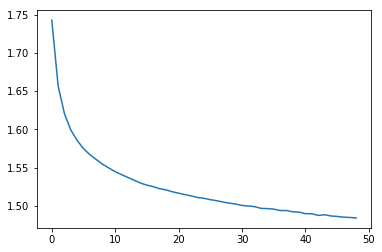

In [131]:
# zoom in 
from matplotlib import pyplot
pyplot.plot([var for (cent,var) in cluster_array])
pyplot.show()

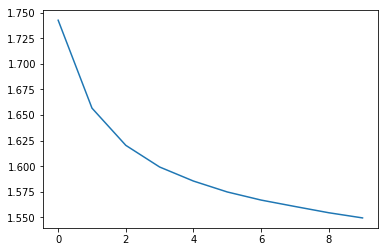

In [135]:
pyplot.plot([var for (cent,var) in cluster_array[0:10]])
pyplot.show()

In [136]:
# fit kmeans for 3 clusters, sklearn used instead of scipy because of familiarity
from sklearn.cluster import KMeans

kmeanModel = KMeans(n_clusters=3).fit(embeddings)
kmeanModel.fit(embeddings)

klabels = kmeanModel.labels_


In [137]:
cluster_1 = klabels == 0
cluster_2 = klabels == 1
cluster_3 = klabels == 2

In [138]:
# tf-idf vectorize text and then find out which n-grams are correlated with each cluster

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(tokenized_text):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each description and vocabulary
    """
    # splits on character n-grams in the range
    # then generates occurence counts of each character n-gram
    # and then performs tf-idf transformation 
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1,3)).fit(tokenized_text)
    text_transformed = tfidf_vectorizer.transform(tokenized_text)
    return text_transformed, tfidf_vectorizer.vocabulary_, tfidf_vectorizer.get_feature_names()

# apply to our own tickets

two_stars_less = sandisk['reviewText'][sandisk['overall'] <= 1]
review_vectors, tfidf_vocab, feature_names = tfidf_features(one_star)



In [139]:
# find n-grams with highest correlation with cluster 1
correl_1 = [(n,np.corrcoef(np.asarray(review_vectors[:,n].todense()).reshape(-1), cluster_1)[0,1]) for n in range(len(feature_names))]
index_1, correlation_1 = zip(*correl_1)
correl_array_1 = np.array(list(correlation_1))
max_idx = np.flip(np.argsort(correl_array)[-30:], axis = 0)
max_vals = correl_array[max_idx]
for i in max_idx: 
    print(feature_names[i], correl_array[i])

00s 0.09060671786018278
000 pictures maybe 0.08749376326345833
00 bucks 0.08251692132871924
00 great 0.0787778719229928
10 0.06913210679170727
00 from 0.0627791474576272
00 bucks but 0.06057109586026598
000 0.05501503482685981
10 am 0.05317525603525928
10 flash 0.051844085505744854
000 byte 0.04479536646755473
0mb 0.04408030291767827
10 and have 0.04405811047708518
10 and now 0.043249073929109136
10 inch 0.04313806528229153
10 note and 0.042248100643867026
10 sd card 0.042180160565504006
10 billing reads 0.04064572465927654
10 1mp camera 0.03800135669712892
04 you have 0.03628034440382322
10 microsdxc card 0.03486242319068984
100 00 0.03384995699265955
10 more for 0.03361487588347965
10 to 15 0.03320200337112696
100mb or so 0.03255558953664474
10 reads are 0.03192851443907796
10 sdhc 0.03189199954748366
10 best bang 0.03165714603980076
10 after 0.031132730461864058
10 8gb21 mb 0.031091367793607466


In [140]:
# find n-grams with highest correlation with cluster 2
correl_2 = [(n,np.corrcoef(np.asarray(review_vectors[:,n].todense()).reshape(-1), cluster_2)[0,1]) for n in range(len(feature_names))]
index_2, correlation_2 = zip(*correl_2)
correl_array_2 = np.array(list(correlation_2))
max_idx_2 = np.flip(np.argsort(correl_array_2)[-30:], axis = 0)
for i in max_idx_2: 
    print(feature_names[i], correl_array_2[i])

the 0.3669235077817829
card 0.2917890171857623
that 0.24092812056563703
to 0.23573494467304215
but 0.20961207488139177
the card 0.2065849344471741
of 0.1815342454039137
on 0.17321152217635602
from 0.17119897245632804
and 0.16424855895294602
class 0.15738355933399434
cards 0.15423704449533718
when 0.15190634458841556
that the 0.15092551534261314
up 0.14897219142067064
microsd 0.1457780021110869
if 0.14452452362306736
you 0.14435116272077994
sandisk 0.1420796907473829
64gb 0.14080488806346764
on the 0.14027503096527205
read 0.13990587785894
class 10 0.13867145910987777
or 0.13696882270554717
this card 0.1360520019524393
format 0.1354132584506488
ve 0.13521275788207854
which 0.1347433031016476
only 0.13461032855718175
of the 0.13363022156086585


In [141]:
# find n-grams with highest correlation with cluster 3
correl_3 = [(n,np.corrcoef(np.asarray(review_vectors[:,n].todense()).reshape(-1), cluster_3)[0,1]) for n in range(len(feature_names))]
index_3, correlation_3 = zip(*correl_3)
correl_array_3 = np.array(list(correlation_3))
max_idx_3 = np.flip(np.argsort(correl_array_3)[-30:], axis = 0)
for i in max_idx_3: 
    print(feature_names[i], correl_array_3[i])

no 0.3525587554743574
problems 0.2263245835383771
not 0.2235522119615029
issues 0.21015305757894745
no problems 0.2077686765395097
no issues 0.16119163593234517
never 0.14694225307542372
to say 0.14639740473050475
any 0.14560128658197144
had no 0.1449213926008408
had any 0.14093926964452605
complaints 0.13967233458528994
not much 0.13818090985151632
had 0.1367448081779986
problem 0.1290643995810422
any issues 0.12749825434060727
much to 0.12479315904715632
problems with 0.12465600028177795
have had no 0.1218007345178071
no complaints 0.12092516699795874
issues with 0.11417716441056214
had no problems 0.11413724768804154
much to say 0.11280551068681031
so far 0.1118710710150486
have had 0.11071115522325364
far 0.1085475229811124
have not 0.1076261792647705
and have 0.10674615236708093
not much to 0.10669044454669031
had any issues 0.10650956505080347


In [123]:
# save results to a csv file

one_star_df = sandisk[sandisk['overall'] <= 1].reset_index()
one_star_df['cluster'] = pd.Series(klabels)
one_star_df.sort_values(by='cluster', ascending = False).to_csv('KMeans_Facebook_Vectors.csv', index = False)

In [124]:
to_save = one_star_df.sort_values(by='cluster')

to_save.to_excel('Facebook_Clustering_Nov_six_clusters.xlsx', index = False)

## Visualize Clusters in 3D

We can get an idea of how the clusters look in space by reducing our >4000 dimensions of the embeddings through PCA and labeling our clusters. This has been useful in the past while trying to tune parameters and see how well the clusters fit the data. 

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
reduced_infersent = pca.fit_transform(embeddings)

In [48]:
[print(i) for i in set(klabels)]

0
1
2


[None, None, None]

In [49]:
# Make a 3D plot
import plotly.offline as off
import plotly.graph_objs as go

traces = []
for i in set(klabels):

    trace = go.Scatter3d(
        x=reduced_infersent[klabels==i,0],
        y=reduced_infersent[klabels==i,1],
        z=reduced_infersent[klabels==i,2],
        text = one_star[klabels==i],
        mode='markers',
        name=str(i),
        hoverinfo = 'text+name',
        marker=dict(
            size=12,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.3))
    traces.append(trace)


data = Data(traces)
layout = Layout(showlegend=True,
                scene=Scene(xaxis=dict(title='Principle Component 1'),
                yaxis=dict(title='Principle Component 2'),
                zaxis=dict(title='Principle Component 3'),))


fig = Figure(data=data, layout=layout)
off.plot(fig)

NameError: name 'Data' is not defined

# Topic Modeling 

In [50]:
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_\']')
STOPWORDS = set(stopwords.words('english'))
tokenizer = nltk.tokenize.TreebankWordTokenizer()

def text_prepare(text):    
    """
        text: a string
        
        return: modified initial string pre-processed 
        1. converting to lower-case
        2. replace special characters with a space
        3. remove othe symbols
        4. remove stopwords
    """
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = text.lower()
    text = [word for word in tokenizer.tokenize(text) if word not in STOPWORDS]
    text = ' '.join(text)
    return text
def text_splitter(texts):
    split_texts = [tokenizer.tokenize(text) for text in texts]
    return split_texts
def dict_counter(split_texts):
    # split, then flatten the nested list of texts
    flattened_list = [word for text in split_texts for word in text]
    # init the dict
    words_counts_dict = dict()
    for word in flattened_list: 
        # if there is no key, get will return 0 (second argument default = 0), and then add 1 
        # if there is a pre-existing key, it will add 1 to the pre-existing number
        # the loop loops through every word occurence
        words_counts_dict[word] = words_counts_dict.get(word, 0) + 1
    return words_counts_dict


In [51]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

def lemmatize_stemming(text):
    return tokenizer.tokenize(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess_split(text):
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = text.lower()
    text = lemmatize_stemming(text)
    text = [word for word in text if word not in STOPWORDS]
    
    return text


In [52]:
preprocess_split('I like green eggs and ham, but last year I didn\'t like them')

['like', 'green', 'eggs', 'ham', 'year', "n't", 'like']

In [54]:
gensim_dict = gensim.corpora.Dictionary(split_texts)

In [55]:
gensim_dict.filter_extremes(keep_n=2000)

In [56]:
gensim_bow_corpus = [gensim_dict.doc2bow(review) for review in split_texts]

In [57]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=3000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(prepared_texts)

In [58]:
import spacy
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import LdaTransformer

%matplotlib inline

# Reduce each document to 2 dimensions (topics) using the sklearn interface.
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

'''search_params = {'n_components': [3,6,9,12,15,18,21,24,27,30], 'learning_decay': [.5, .7, .9]}
model = GridSearchCV(lda_model, param_grid = search_params)

docvecs = model.fit(data_vectorized)'''

"search_params = {'n_components': [3,6,9,12,15,18,21,24,27,30], 'learning_decay': [.5, .7, .9]}\nmodel = GridSearchCV(lda_model, param_grid = search_params)\n\ndocvecs = model.fit(data_vectorized)"

In [59]:
'''# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

'''

NameError: name 'model' is not defined

In [ ]:
'''pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel'''

In [ ]:
'''# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()'''

In [76]:
a = lda_cust(4, max_iter = 30)
b = a.fit(data_vectorized)

In [60]:
def lda_cust(n, max_iter = 30): 
    model = LatentDirichletAllocation(n_components=n,               # Number of topics
                                      max_iter=10, # Max learning iterations
                                      learning_decay = 0.5, 
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
    return model

names = ['lda_model_{}'.format(x) for x in range(3,11)]
numbers = range(3,11)

lda_model_dict = {}
for model, number in zip (names, numbers): 
    print('fitting LDA model for {} topics . . . '.format(number))
    lda_model_dict[model] = lda_cust(number, max_iter = 30).fit(data_vectorized)
    print('LDA for {} topics is done'.format(number))
    

fitting LDA model for 3 topics . . . 
LDA for 3 topics is done
fitting LDA model for 4 topics . . . 
LDA for 4 topics is done
fitting LDA model for 5 topics . . . 
LDA for 5 topics is done
fitting LDA model for 6 topics . . . 
LDA for 6 topics is done
fitting LDA model for 7 topics . . . 
LDA for 7 topics is done
fitting LDA model for 8 topics . . . 
LDA for 8 topics is done
fitting LDA model for 9 topics . . . 
LDA for 9 topics is done
fitting LDA model for 10 topics . . . 
LDA for 10 topics is done


In [68]:
lda_model_dict.keys()

dict_keys(['lda_model_3', 'lda_model_4', 'lda_model_5', 'lda_model_6', 'lda_model_7', 'lda_model_8', 'lda_model_9', 'lda_model_10'])

In [ ]:
names[0]

In [72]:
lda_model_dict['lda_model_4']

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [88]:
panel = pyLDAvis.sklearn.prepare(lda_model_dict['lda_model_6'], data_vectorized, vectorizer, mds='tsne')
pyLDAvis.display(panel)

/Users/Alex.Shypula@ibm.com/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))